In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from mockfactory import (EulerianLinearMock, LagrangianLinearMock,
                         Catalog, BoxCatalog, RandomBoxCatalog, box_to_cutsky,
                         DistanceToRedshift, TabulatedRadialMask, HealpixAngularMask,
                         utils, setup_logging)
from cosmoprimo.fiducial import DESI
import fitsio
from astropy.table import Table, vstack

In [2]:
def nbar_angular2comoving(nbar,zmin,zmax):
    # change angular density to comoving density
    cosmo = DESI()
    V23 = 4*np.pi/3 * (cosmo.comoving_radial_distance(zmax)**3 - cosmo.comoving_radial_distance(zmin)**3)
    print(f"comoving volume between {zmin} and {zmax}: {V23:.2e} Mpc3 / h3")

    # create a conversion factor so we can change nbar from deg^-2 to h^3/Mpc^3  
    Asky = 4*np.pi*(180/np.pi)**2 #41252.96124941928#41253# square deg
    conv = V23 /Asky # Mpc^3 per square deg # Mpc^3/deg^2
    print(f"conversion factor {conv:.2e}")
    
    nbar_deg = nbar # deg^-2
    nb = nbar_deg / conv
    print(f"converted nbar={nbar_deg} 1 / deg2 to nbar={nb:.2e} h3 / Mpc3")
    return nb

import healpy as hp
def hpixsum(nside, ra, dec, weights=None):
    hpix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra))
    npix = hp.nside2npix(nside)
    weight_hp = np.bincount(hpix, weights=weights, minlength=npix)
    return weight_hp

In [3]:
# Set up logging
setup_logging()
# redshift parameters
zmin = 2.75
zmax = 3.25
zeff = (zmax + zmin)/2.
print(f"zmin={zmin}, zmax={zmax}, zeff={zeff}")

# change angular density to comoving density
nb_deg = 2500. # nbar in deg^-2 
nb = nbar_angular2comoving(nb_deg,zmin,zmax) # give function nbar in deg^-2 

# Set other parameters
bias, nbar, nmesh, boxsize = 3.0, nb, 1024, 8000.
los = 'x' # line of sight

# Loading DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=zeff)
dist = cosmo.comoving_radial_distance(zeff)
dmin = cosmo.comoving_radial_distance(zmin)
dmax = cosmo.comoving_radial_distance(zmax)
f = cosmo.sigma8_z(z=zeff,of='theta_cb')/cosmo.sigma8_z(z=zeff,of='delta_cb') # growth rate
boxcenter = [dist, 0, 0]

zmin=2.75, zmax=3.25, zeff=3.0
comoving volume between 2.75 and 3.25: 7.92e+10 Mpc3 / h3
conversion factor 1.92e+06
converted nbar=2500.0 1 / deg2 to nbar=1.30e-03 h3 / Mpc3
[000001.16] [0/1] 04-14 11:30  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000001.16] [0/1] 04-14 11:30  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000001.16] [0/1] 04-14 11:30  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000001.17] [0/1] 04-14 11:30  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000001.17] [0/1] 04-14 11:30  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_clie

In [4]:
%%time
#load cats
base_dir = os.path.join(os.getenv('PSCRATCH'), 'lognormal_mocks')
cutsky_dir = os.path.join(base_dir, 'cutsky')

file_id = f"{bias}_{nb_deg}_{nmesh}_{boxsize}_{zeff}"
fn1 = os.path.join(cutsky_dir, 'data_cutsky_'+file_id+'_1.fits')
data1 = Table.read(fn1)
fn2 = os.path.join(cutsky_dir, 'randoms_cutsky_'+file_id+'_2.fits')
data2 = Table.read(fn2)

data_cutsky = vstack([data1,data2])

CPU times: user 1.05 s, sys: 1.03 s, total: 2.08 s
Wall time: 2.08 s


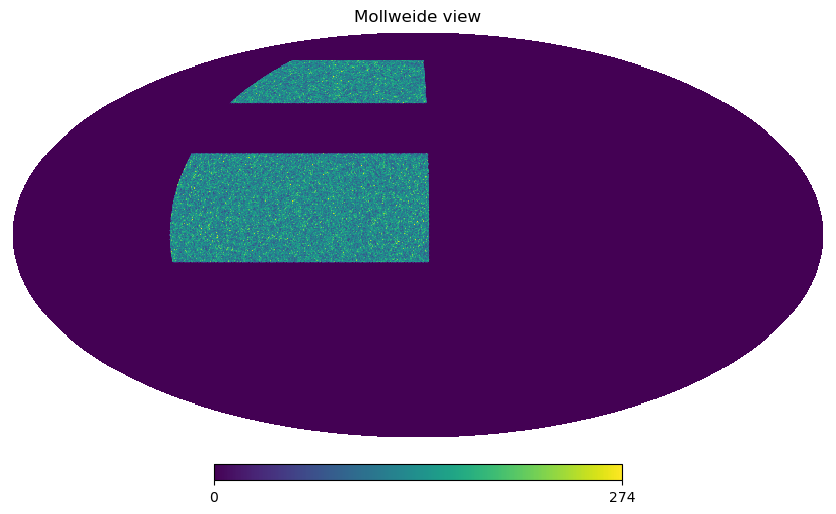

In [5]:
nside = 256
data_hpmap = hpixsum(nside,data_cutsky['RA'],data_cutsky['DEC'])
hp.mollview(data_hpmap, rot=180)

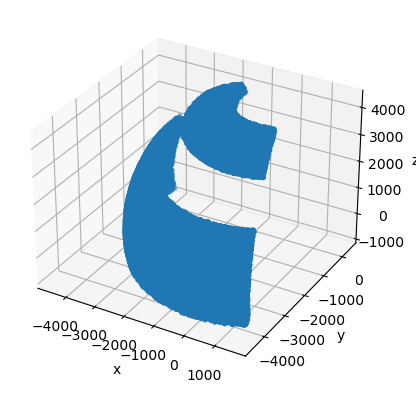

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*data_cutsky['Position'][::100].T, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

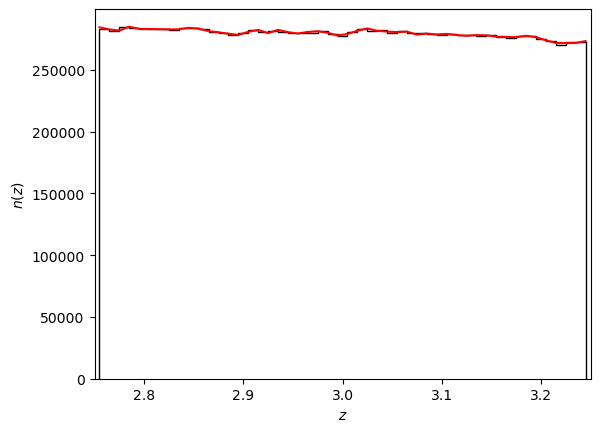

In [6]:
bins=50
z = np.linspace(zmin, zmax, bins+1)
bc = (z[:-1] + z[1:])/2

dndz = np.histogram(data_cutsky['Z'], bins=z)[0]
plt.hist(data_cutsky['Z'], bins=bc, histtype='step', color='k')
plt.plot(bc,dndz,color='r')
plt.ylabel(r"$n(z)$")
plt.xlabel(r"$z$")
plt.xlim(zmin,zmax)
plt.show()

In [9]:
# Let us apply some redshift cuts
z = np.linspace(zmin, zmax, 51)
nbarz = np.exp(-30. * (z - 1.0)**2 / 2.)  # in (Mpc/h)^(-3)
mask_radial = TabulatedRadialMask(z=z, nbar=nbarz)
mask = mask_radial(data_cutsky['Z'], seed=84)

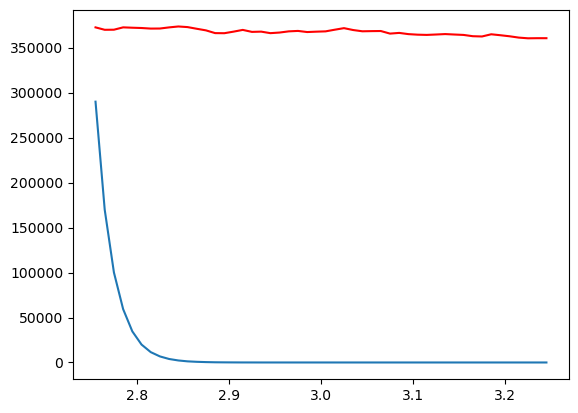

In [49]:
bins=50
z = np.linspace(zmin, zmax, bins+1)
bc = (z[:-1] + z[1:])/2

dndz = np.histogram(data_cutsky['Z'], bins=z)[0]
#plt.hist(data_cutsky['Z'], bins=bc, histtype='step', color='k')
plt.plot(bc,dndz, color='r')

dndz = np.histogram(data_cutsky[mask]['Z'], bins=z)[0]
plt.plot(bc,dndz)
#plt.hist(data_cutsky[mask]['Z'], bins=bc, histtype='step')
plt.show()

In [53]:
rarange = np.array([0, 120])
print(*rarange)

0 120


In [4]:
# Set up logging
setup_logging()
# redshift parameters
zmin = 2.75
zmax = 3.25
zeff = (zmax + zmin)/2.
print(f"zmin={zmin}, zmax={zmax}, zeff={zeff}")

# change angular density to comoving density
nb_deg = 2500 # nbar in deg^-2 
nb = nbar_angular2comoving(nb_deg,zmin,zmax) # give function nbar in deg^-2 

# Set other parameters
bias, nbar, nmesh, boxsize = 3.0, nb, 256, 8000.
los = 'x' # line of sight

# Loading DESI fiducial cosmology
cosmo = DESI()
power = cosmo.get_fourier().pk_interpolator().to_1d(z=zeff)
dist = cosmo.comoving_radial_distance(zeff)
dmin = cosmo.comoving_radial_distance(zmin)
dmax = cosmo.comoving_radial_distance(zmax)
f = cosmo.sigma8_z(z=zeff,of='theta_cb')/cosmo.sigma8_z(z=zeff,of='delta_cb') # growth rate
boxcenter = [dist, 0, 0]

zmin=2.75, zmax=3.25, zeff=3.0
comoving volume between 2.75 and 3.25: 7.92e+10 Mpc3 / h3
conversion factor 1.92e+06
converted nbar=2500 1 / deg2 to nbar=1.30e-03 h3 / Mpc3
[000001.86] [0/1] 04-07 13:20  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000001.86] [0/1] 04-07 13:20  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000001.86] [0/1] 04-07 13:20  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000001.87] [0/1] 04-07 13:20  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000001.87] [0/1] 04-07 13:20  jax._src.lib.xla_bridge   INFO     Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client

In [4]:
drange, rarange, decrange = box_to_cutsky(boxsize=boxsize, dmax=dmax)#dist + boxsize / 2.)
# Moving RA - range to positive values, just for better display
rarange = np.array(rarange) + np.abs(np.min(rarange))
print('Choosing distance, RA, Dec ranges [{:.2f} - {:.2f}], [{:.2f} - {:.2f}], [{:.2f} - {:.2f}].'.format(*drange, *rarange, *decrange))

Choosing distance, RA, Dec ranges [0.00 - 4540.37], [0.00 - 123.52], [-61.76 - 61.76].


In [ ]:
%%time
mock = LagrangianLinearMock(power, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=None, unitary_amplitude=False)
# this is Lagrangian bias, Eulerian bias - 1
mock.set_real_delta_field(bias=bias-1)
mock.set_analytic_selection_function(nbar=nbar)
mock.poisson_sample(seed=None)
mock.set_rsd(f=f, los=los)
data = mock.to_catalog()
# We've got data, now turn to randoms
from mockfactory.make_survey import RandomBoxCatalog
randoms = RandomBoxCatalog(nbar=4.*nbar, boxsize=boxsize, seed=None) # i put 4 as an arbitrary factor for the example

[000002.05] [0/1] 04-07 12:31  LagrangianLinearMock      INFO     White noise generated.
[000002.45] [0/1] 04-07 12:31  LagrangianLinearMock      INFO     Poisson sampling done, total number of objects is 667054592.
[000011.42] [0/1] 04-07 12:31  LagrangianLinearMock      INFO     Catalog produced. Assigning in cell shift.


NameError: name 'setup_logging' is not defined

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*data['Position'][::100].T, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [12]:
#-----------------------------------------------------
# Let us cut the above box to some geometry
#drange = [dist - size/3., dist + size/3.]
drange = [dist - (dist-dmin), dist + (dmax-dist)]
rarange = [175, 290]
decrange = [-10, 70]
print('Choosing distance, RA, Dec ranges [{:.2f} - {:.2f}], [{:.2f} - {:.2f}], [{:.2f} - {:.2f}].'.format(*drange, *rarange, *decrange))
# noutput = None will cut as many catalogs as possible
data_cutsky = data.cutsky(drange=drange, rarange=rarange, decrange=decrange)
randoms_cutsky = randoms.cutsky(drange=drange, rarange=rarange, decrange=decrange)

Choosing distance, RA, Dec ranges [1936.43 - 2454.58], [175.00 - 290.00], [-10.00 - 70.00].


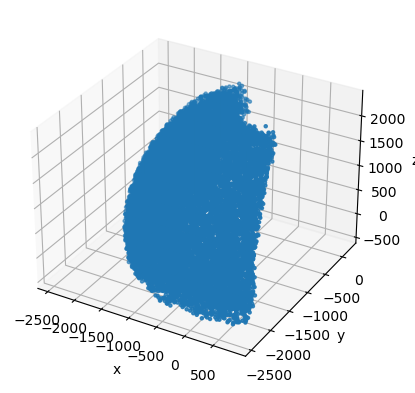

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*data_cutsky['Position'][::100].T, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()